# Import Library

In [1]:
# Standard Libraries
import datetime
import json
import os
import pickle
import random
import shutil
import zipfile
from pathlib import Path

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Image Processing
import cv2
from PIL import Image
from skimage import img_as_ubyte, io
from skimage.exposure import adjust_gamma
from skimage.transform import AffineTransform, resize, rotate, warp
from skimage.util import random_noise

# Progress Bar
from tqdm import tqdm
from tqdm.notebook import tqdm as tq

# Deep Learning - TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import TFSMLayer

# TensorFlow Keras Modules
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import (
    DenseNet121,
    EfficientNetB4,
    InceptionV3,
    MobileNet,
    MobileNetV2
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    Callback
)
from tensorflow.keras.layers import (
    Input,
    InputLayer,
    Conv2D,
    SeparableConv2D,
    MaxPooling2D,
    MaxPool2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory

# Data Augmentation - Albumentations
from albumentations import (
    Affine,
    Blur,
    CLAHE,
    Compose,
    GaussNoise,
    HorizontalFlip,
    HueSaturationValue,
    OneOf,
    RandomBrightnessContrast,
    RandomGamma,
    Resize,
    VerticalFlip
)

# Sklearn Utilities
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Platform Integration (Kaggle & Colab)
import kagglehub
from google.colab import files

Mengabaikan peringatan

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Load Dataset

Mengunduh dataset dari kaggle

In [3]:
path = kagglehub.dataset_download("aryashah2k/mango-leaf-disease-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mango-leaf-disease-dataset


Memindahkan dataset ke writable folder

In [4]:
src = path
dst = '/content/Dataset'

if not os.path.exists(dst):
    shutil.copytree(src, dst)

Mendefinisikan path ke dataset dan daftar kelas

In [5]:
dataset_path = '/content/Dataset'
classes = os.listdir(dataset_path)

# Mengecek isi dataset
print(classes)

['Anthracnose', 'Cutting Weevil', 'Sooty Mould', 'Powdery Mildew', 'Healthy', 'Die Back', 'Bacterial Canker', 'Gall Midge']


Mengecek gambar dari setiap kelas

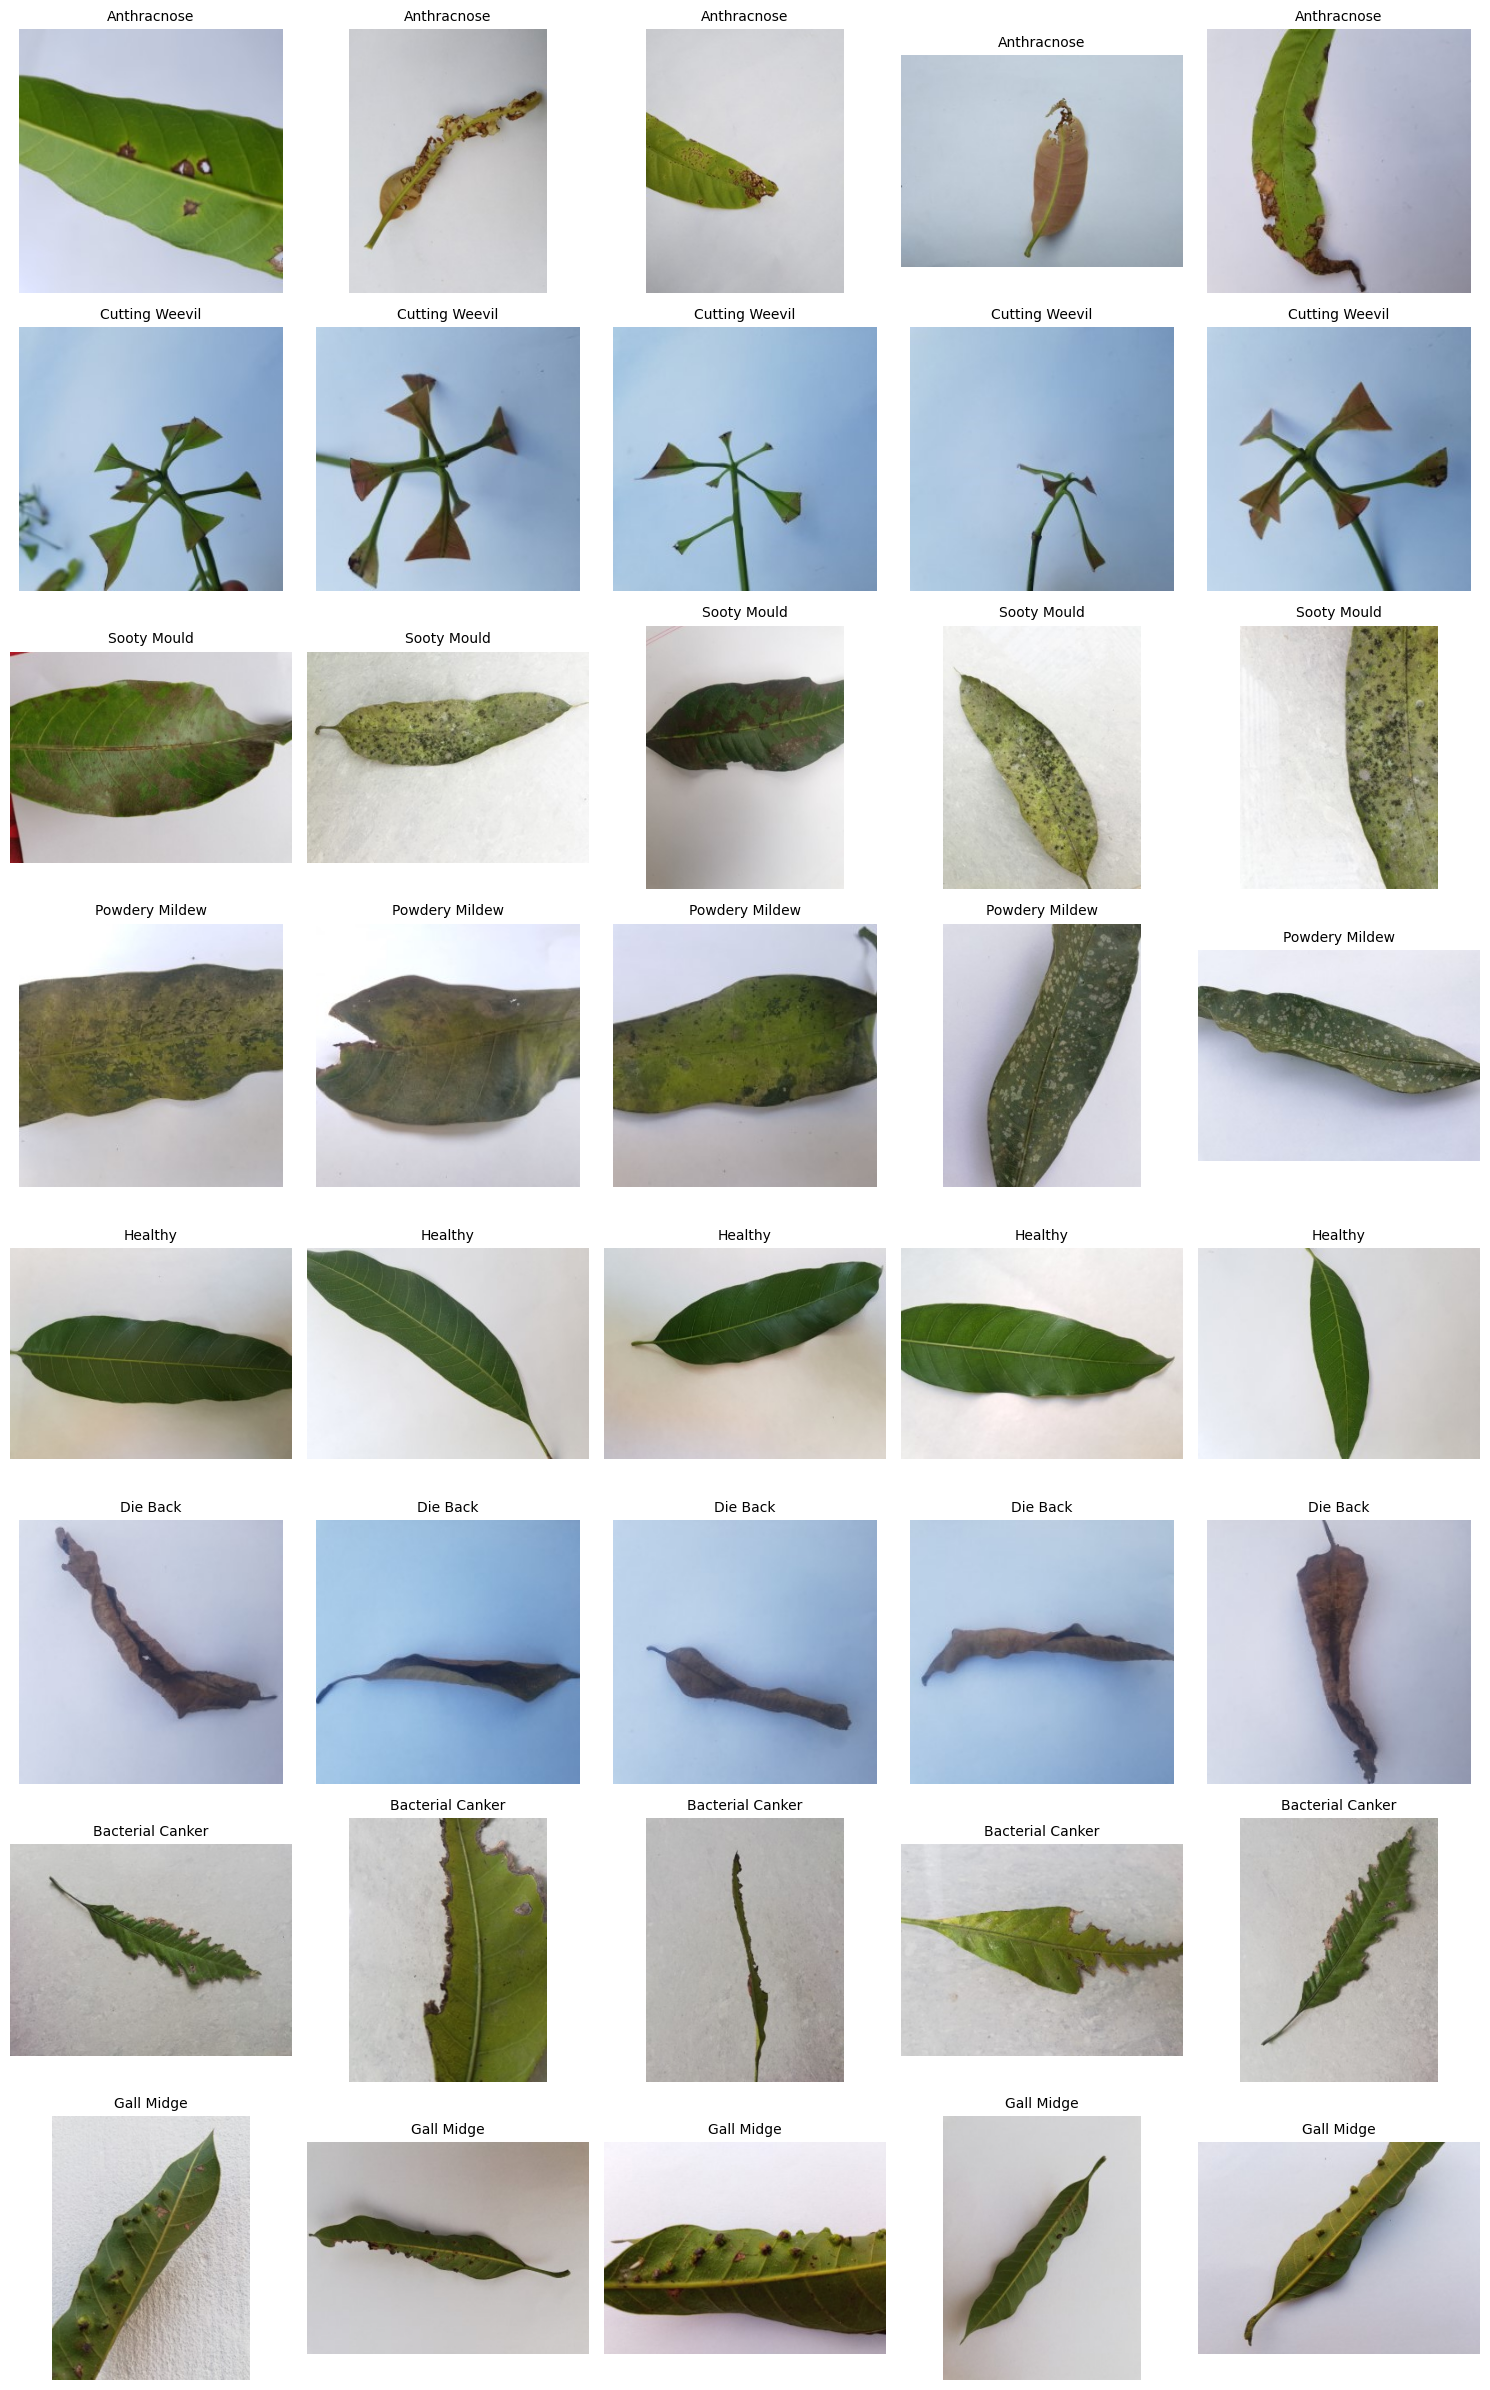

In [6]:
# Setup plot dengan ukuran yang dinamis berdasarkan jumlah kelas
plt.figure(figsize=(15, 3 * len(classes)))

# Loop melalui setiap kelas
for class_index, disease_class in enumerate(classes):
    class_folder_path = os.path.join(dataset_path, disease_class)
    image_files = os.listdir(class_folder_path)[:5]  # Ambil 5 gambar pertama

    # Loop melalui setiap gambar dalam kelas
    for image_index, image_file in enumerate(image_files):
      full_image_path = os.path.join(class_folder_path, image_file)

      # Menyipkan posisi subplot
      subplot_position = class_index * 5 + image_index + 1
      plt.subplot(len(classes), 5, subplot_position)

      # Menampilkan gambar
      plt.imshow(Image.open(full_image_path))
      plt.title(disease_class, fontsize=10)
      plt.axis('off')

plt.tight_layout()
plt.show()

Mengecek distribusi data

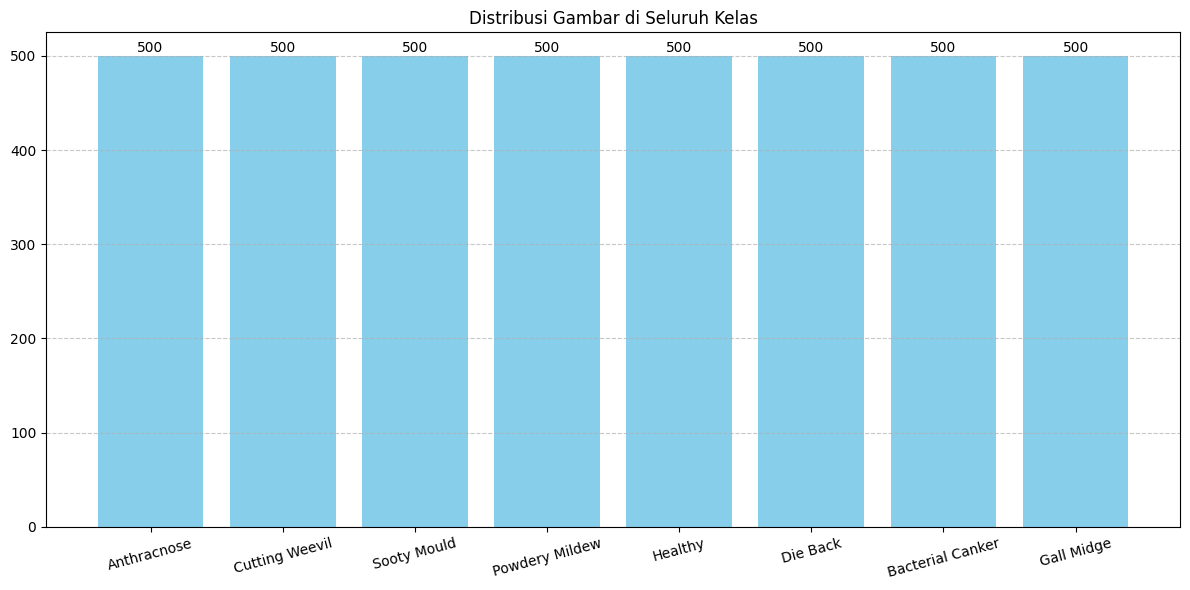

In [7]:
# Hitung jumlah gambar per kelas
imageCount = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar di Seluruh Kelas")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Preparation

Split dataset

In [8]:
def split_dataset_folder(base_dir, output_dir, train_size=0.7, val_size=0.15, test_size=0.15):
    assert round(train_size + val_size + test_size, 2) == 1.0, "Split ratio harus 1.0 total"

    classes = os.listdir(base_dir)

    for split in ['train', 'valid', 'test']:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    for cls in classes:
        cls_path = os.path.join(base_dir, cls)
        images = os.listdir(cls_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_size * n_total)
        n_val = int(val_size * n_total)

        train_files = images[:n_train]
        val_files = images[n_train:n_train + n_val]
        test_files = images[n_train + n_val:]

        for file_set, split in zip([train_files, val_files, test_files], ['train', 'valid', 'test']):
            for file in file_set:
                src = os.path.join(cls_path, file)
                dst = os.path.join(output_dir, split, cls, file)
                shutil.copy(src, dst)

# Contoh penggunaan
split_dataset_folder(
    base_dir='/content/Dataset',
    output_dir='/content/Split-Dataset',
    train_size=0.7,
    val_size=0.15,
    test_size=0.15
)

Mengecek jumlah data pada train set

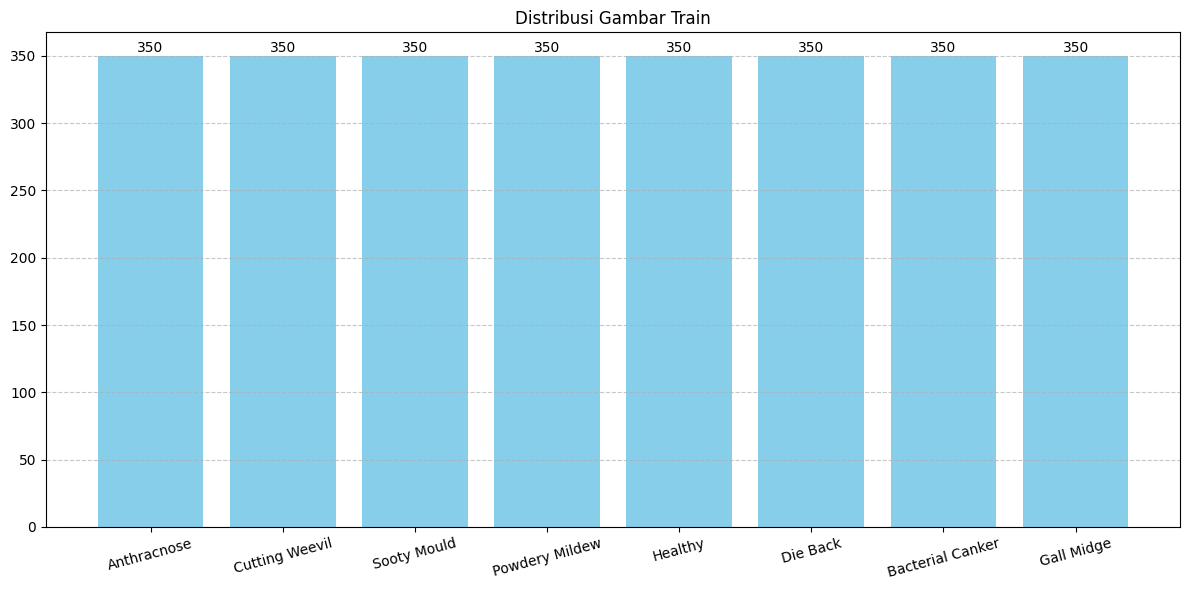

In [9]:
train_path = '/content/Split-Dataset/train'
imageCount = {class_name: len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar Train")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Membuat data generator untuk train dan validation

In [10]:
def train_val_generators_from_directory(base_dir):

    datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        rotation_range=80,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    train_generator = datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'train'),
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_generator = datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'valid'),
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator

train_generator, val_generator = train_val_generators_from_directory("/content/Split-Dataset")

Found 2800 images belonging to 8 classes.
Found 600 images belonging to 8 classes.


Membuat data generator untuk test

In [11]:
def test_generator_from_directory(base_dir):
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    test_generator = test_datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'test'),
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator

test_generator = test_generator_from_directory("/content/Split-Dataset")

Found 600 images belonging to 8 classes.


# Model Development

Membangun model

In [12]:
def build_model(input_shape=(150, 150, 3), n_classes=8):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape, name='input_layer'))

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), name='block1_pool'))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), name='block2_pool'))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
    model.add(MaxPooling2D((2, 2), name='block3_pool'))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
    model.add(MaxPooling2D((2, 2), name='block4_pool'))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
    model.add(MaxPooling2D((2, 2), name='block5_pool'))

    # Fully Connected
    model.add(Flatten(name='flatten'))
    model.add(Dense(512, activation='relu', name='dense'))
    model.add(Dropout(0.5, name='dropout'))
    model.add(Dense(n_classes, activation='softmax', name='dense_1'))

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Inisialisasi model baru
model = build_model()

# Simpan bobot awal
initial_weights = model.get_weights()

# Reset model ke kondisi awal sebelum fit
model.set_weights(initial_weights)

Melihat arsitektur model

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,913,608 (72.15 MB)

 Trainable params: 18,913,608 (72.15 MB)

 Non-trainable params: 0 (0.00 B)

Membuat callback

In [14]:
class AccuracyThresholdCallback(Callback):
    def __init__(self, train_acc=0.96, val_acc=0.96):
        super(AccuracyThresholdCallback, self).__init__()
        self.train_acc = train_acc
        self.val_acc = val_acc

    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy is not None and val_accuracy is not None:
            if train_accuracy >= self.train_acc and val_accuracy >= self.val_acc:
                print("Training model dihentikan karena model telah mencapai target akurasi")
                self.model.stop_training = True

# Callback untuk menghentikan model jika val_loss tidak membaik
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=3,
    min_lr=1e-6,
    verbose=2
)

Melatih model

In [15]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1,
    callbacks=[early_stop, AccuracyThresholdCallback(train_acc=0.96, val_acc=0.96), reduce_lr]
)

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1303 - loss: 2.0622 - val_accuracy: 0.2600 - val_loss: 1.7891 - learning_rate: 1.0000e-04
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 665ms/step - accuracy: 0.2895 - loss: 1.6843 - val_accuracy: 0.3283 - val_loss: 1.5115 - learning_rate: 1.0000e-04
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 657ms/step - accuracy: 0.3277 - loss: 1.5702 - val_accuracy: 0.3817 - val_loss: 1.4355 - learning_rate: 1.0000e-04
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 662ms/step - accuracy: 0.3541 - loss: 1.4621 - val_accuracy: 0.4833 - val_loss: 1.2967 - learning_rate: 1.0000e-04
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 693ms/step - accuracy: 0.4620 - loss: 1.3747 - val_accuracy: 0.5733 - val_loss: 1.1529 - learning_rate: 1.0000e-04
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 644ms/step - accuracy: 0.5852 - loss: 1.1222 - val_accuracy: 0.6550 - val_loss: 0.9873 - learning_rate: 1.0000e-04
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 647ms/step - accura

# Evaluation

Mengecek performa model pada test set

In [28]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9821 - loss: 0.0491

Test Accuracy: 0.9567
Test Loss: 0.1112


Mengecek perkembangan performa model dengan grafik

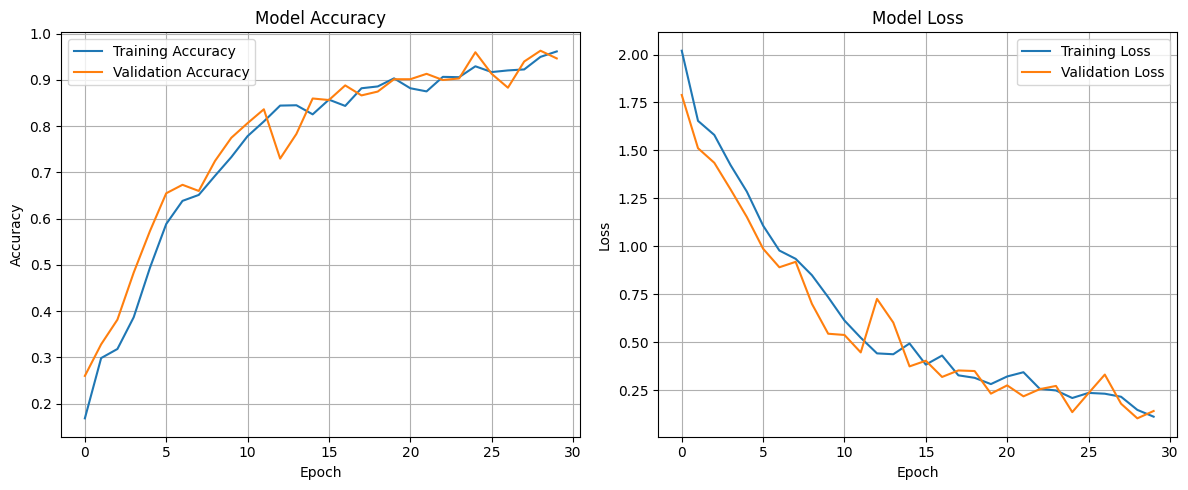

In [17]:
def plot_model_performance(history):
    # Akurasi
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsi visualisasi
plot_model_performance(history)

Mengecek performa model dengan laporan klasifikasi

In [18]:
# Prediksi pada test set
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Ambil kelas prediksi

# Label asli
y_true = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
Classification Report:

                  precision    recall  f1-score   support

     Anthracnose       0.95      1.00      0.97        75
Bacterial Canker       0.94      0.97      0.95        75
  Cutting Weevil       1.00      1.00      1.00        75
        Die Back       1.00      1.00      1.00        75
      Gall Midge       0.93      0.91      0.92        75
         Healthy       1.00      0.96      0.98        75
  Powdery Mildew       0.95      0.92      0.93        75
     Sooty Mould       0.89      0.89      0.89        75

        accuracy                           0.96       600
       macro avg       0.96      0.96      0.96       600
    weighted avg       0.96      0.96      0.96       600



Mengecek performa model dengan confussion matrix

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


<Figure size 800x600 with 0 Axes>

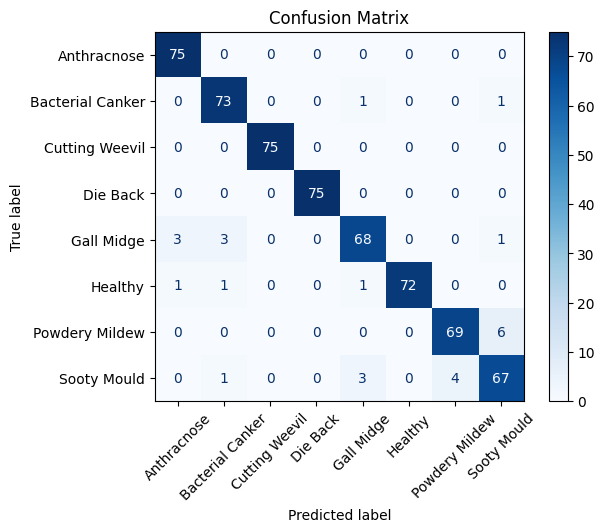

In [19]:
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

class_names = list(test_generator.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

Inference testing dengan gambar dari testing set

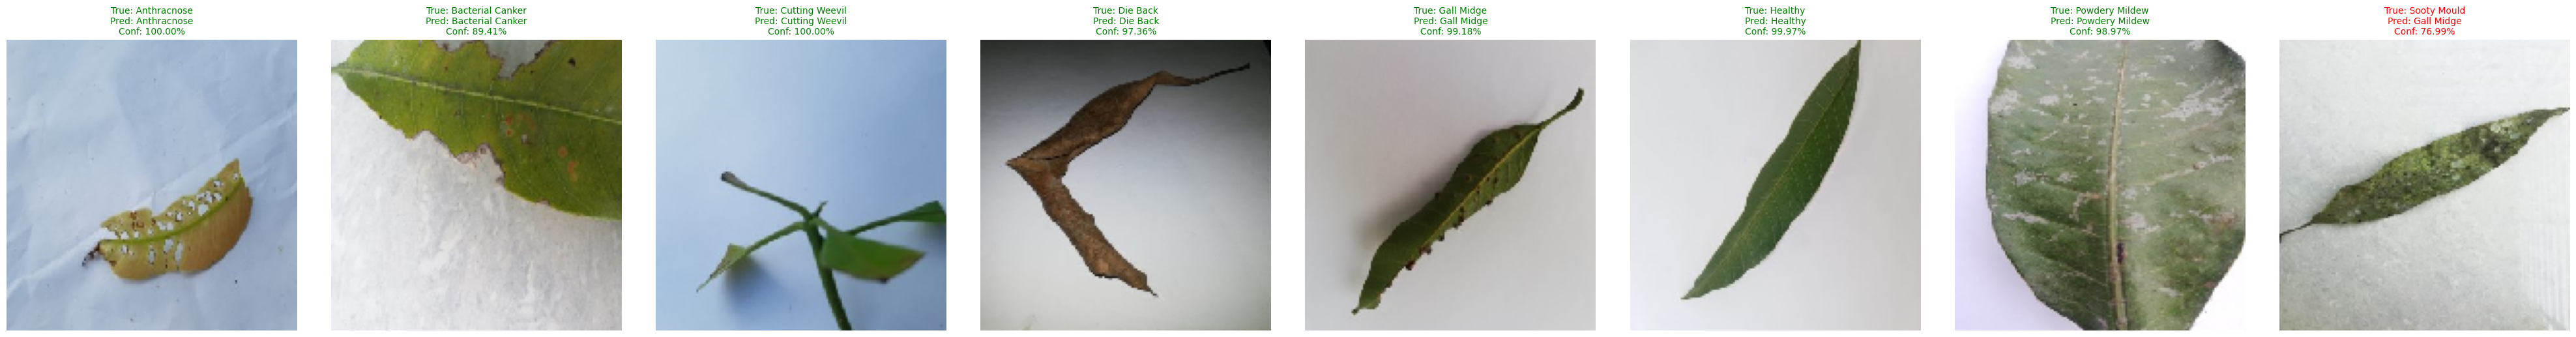

In [20]:
def predict_sample_images(test_dir, model, target_size=(150, 150), class_indices=None):
    inverse_class_indices = {v: k for k, v in class_indices.items()}

    class_names = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
    num_classes = len(class_names)

    fig, axes = plt.subplots(1, num_classes, figsize=(5 * num_classes, 5))
    if num_classes == 1:
        axes = [axes]  # jika hanya satu kelas

    for i, class_name in enumerate(class_names):
        class_folder = os.path.join(test_dir, class_name)
        image_list = os.listdir(class_folder)
        if not image_list:
            continue

        # Ambil satu gambar secara acak
        image_name = random.choice(image_list)
        img_path = os.path.join(class_folder, image_name)

        # Preprocess gambar
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img) / 255.0
        img_array_exp = np.expand_dims(img_array, axis=0)

        # Prediksi
        prediction = model.predict(img_array_exp, verbose=0)
        pred_index = np.argmax(prediction)
        pred_label = inverse_class_indices[pred_index]
        confidence = prediction[0][pred_index] * 100

        # Visualisasi
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f"True: {class_name}\nPred: {pred_label}\nConf: {confidence:.2f}%",
            color='green' if pred_label == class_name else 'red',
            fontsize=10
        )

    plt.tight_layout()
    plt.show()

test_dir = "/content/Split-Dataset/test"
predict_sample_images(
    test_dir=test_dir,
    model=model,  # model yang sudah Anda latih
    target_size=(150, 150),
    class_indices=test_generator.class_indices  # pakai dari test_generator
)

Inference testing dengan gambar yang diberikan oleh user

Saving antraknosa.jpg to antraknosa.jpg


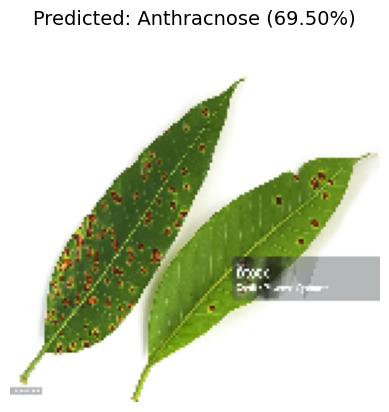

In [21]:
def predict_uploaded_image(model, class_indices, target_size=(150, 150)):
    # Upload file
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Load dan preprocess gambar
        img = image.load_img(filename, target_size=target_size)
        img_array = image.img_to_array(img) / 255.0
        img_array_exp = np.expand_dims(img_array, axis=0)

        # Prediksi
        prediction = model.predict(img_array_exp, verbose=0)
        pred_index = np.argmax(prediction)
        confidence = prediction[0][pred_index] * 100

        # Konversi indeks ke label kelas
        inverse_class_indices = {v: k for k, v in class_indices.items()}
        predicted_label = inverse_class_indices[pred_index]

        # Tampilkan hasil
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)", fontsize=14)
        plt.show()

predict_uploaded_image(model, class_indices=test_generator.class_indices)

# Convert and Save Model

Mempersiapkan folder untuk menampung model

In [22]:
os.makedirs("saved_model", exist_ok=True)
os.makedirs("tfjs_model", exist_ok=True)
os.makedirs("pkl_model", exist_ok=True)

Menyimpan model dama format savedmodel

In [23]:
model.export('/content/saved_model/')

Saved artifact at '/content/saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  138659354836240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659354836816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659354836432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659336652752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659336655440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659336656208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659336655248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659336654864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659336656976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138659336658128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1386593366

Menyimpan model dalam format TFJSModel

In [24]:
!pip install tensorflowjs

saved_model_loc = "/content/saved_model/"
# Konversi ke format TensorFlow.js dari SavedModel
!tensorflowjs_converter --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    {saved_model_loc} /content/tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-06-06 08:31:29.100257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749198689.120483    6539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attem

Menyimpan model dalam format pkl

In [25]:
save_dir = '/content/pkl_model'
model.save(os.path.join(save_dir, 'model_cassava.h5'))
with open(os.path.join(save_dir, 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

Melakukan zip pada model yang telah disimpan untuk mempermudah proses download

In [26]:
folders_to_zip = ['pkl_model', 'saved_model', 'tfjs_model']
output_zip_path = 'exported_models.zip'

with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in folders_to_zip:
        for root, dirs, files in os.walk(folder):
            for file in files:
                filepath = os.path.join(root, file)
                arcname = os.path.relpath(filepath, start=os.path.dirname(folder))
                zipf.write(filepath, arcname)

In [27]:
test_generator.class_indices

{'Anthracnose': 0,
 'Bacterial Canker': 1,
 'Cutting Weevil': 2,
 'Die Back': 3,
 'Gall Midge': 4,
 'Healthy': 5,
 'Powdery Mildew': 6,
 'Sooty Mould': 7}